Los objetivos de este notebook son:
- Ilustrar como crear un `Dataset` de PyTorch que permita obtener batches de datos basados en una serie de tiempo, dada una ventana histórica predictiva y una ventana futura a predecir.
- Ilustrar el manejo del módulo `nn.LSTM` de PyTorch para crear capas de neuronas con memoria de largo plazo.
- Aplicar lo aprendido a un proceso de pronóstico de una serie de tiempo de la función seno.

Este notebook está basado en material encontrado en:
- *PyTorch*, https://pytorch.org/

# 1. Establecimiento del ambiente de desarrollo y ejecución.

Preparamos el ambiente de desarrollo y ejecución, cargando librerías, verificando el dispositivo disponible (CPU o CUDA), y reseteando el seed.

In [1]:
import numpy as np
import pandas as pd
import os, random, math, time
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
if torch.cuda.is_available():
    print("Utilizamos la primera GPU disponible")
    DEVICE=device = torch.device('cuda:0')
    os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
else:
    print("No hay GPU, toca correr todo en CPU")
    DEVICE=device = torch.device('cpu')

DEVICE

Utilizamos la primera GPU disponible


device(type='cuda', index=0)

In [3]:
def reset_seed():
    SEED = 42
    torch.backends.cudnn.enabled = True
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [4]:
sns.set_style('whitegrid')

# 2. Datos sintéticos de estudio

Vamos a crear un dataset sencillo con la función sinusoidal, utilizando:
- `torch.linspace` : que permite obtener un tensor con una secuencia de valores ordenados y separados entre ellos equidistantemente. Recibe como parámetros el primer, último elemento de la secuencia (no incluido), y el número de puntos a generar.
- `torch.rand`: que permite generar valores aleatorios usando una distribución uniforme.
- `torch.randn`: que permite generar valores aleatorios usando una distribución normal, teniendo como valores por defecto de sus parámetros media 0 y stdev 1, para utilizar por defecto una distribución normal estándar
- `torch.sin`: que recibe un tensor de valores en radianes y retorna un tensor con la función *seno* aplicada a los mismos.

In [5]:
radMin = -30 # comienzo de la secuencia de los inputs (x) en radianes
radMax = 30 # final de la secuencia de los inputs (x) en radianes
numPuntos = 3000
nivel_ruido_x = 0.5 # nivel de ruido agregado a los inputs (x)
nivel_ruido_y = 0.2 # nivel de ruido agregado a las salidas (y)

Vamos a generar datos aleatorios equidistantes que servirán como inputs, a los que agregaremos un ruido uniforme para eliminar la equidistancia. Veamos el resultado de aplicar la función seno a estos valores.

In [6]:
reset_seed()
torch.linspace(radMin, radMax, numPuntos)

tensor([-30.0000, -29.9800, -29.9600,  ...,  29.9600,  29.9800,  30.0000])

In [7]:
torch.rand(numPuntos)[:10]

tensor([0.8823, 0.9150, 0.3829, 0.9593, 0.3904, 0.6009, 0.2566, 0.7936, 0.9408,
        0.1332])

In [8]:
torch.linspace(radMin, radMax, numPuntos) + nivel_ruido_x*torch.rand(numPuntos)

tensor([-29.5575, -29.5426, -29.6247,  ...,  29.9783,  30.0210,  30.0006])

Text(0, 0.5, 'Y')

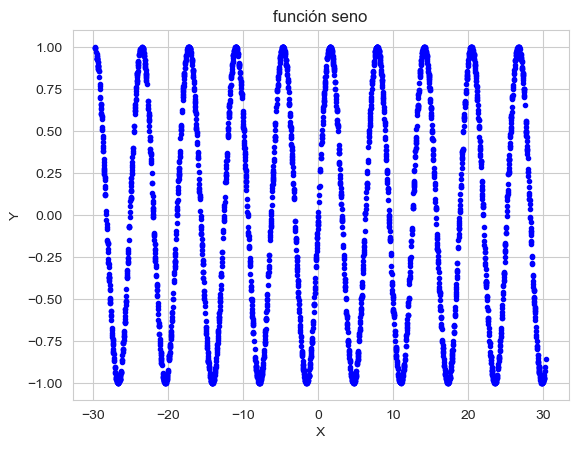

In [9]:
reset_seed()
x = torch.linspace(radMin, radMax, numPuntos) + nivel_ruido_x*torch.rand(numPuntos)
torch.sort(x)
y = torch.sin(x)

# Plotting
plt.scatter(x.numpy(), y.numpy(), color = 'blue', marker = ".")
plt.title("función seno")
plt.xlabel("X")
plt.ylabel("Y")

Vamos ahora a simular ruido en los datos de salida.

Text(0, 0.5, 'Y')

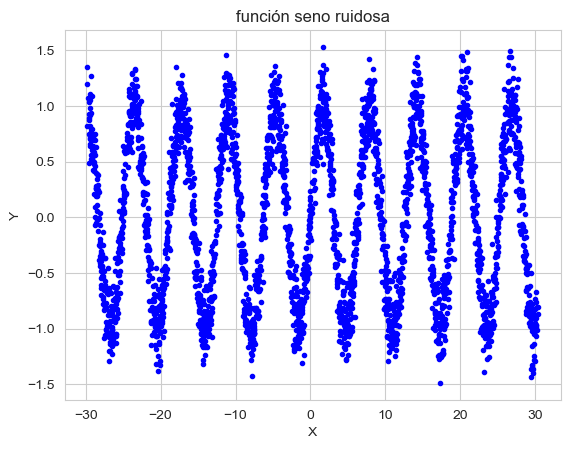

In [10]:
reset_seed()
ruido_y = torch.randn(numPuntos)
y = torch.sin(x) + nivel_ruido_y*torch.randn(numPuntos)

# Plotting
plt.scatter(x.numpy(), y.numpy(), color = 'blue', marker = ".")
plt.title("función seno ruidosa")
plt.xlabel("X")
plt.ylabel("Y")

Vamos a crear ahora una clase que represente el proceso generador de este dataset a partir de la clase `Dataset` de PyTorch. Necesitamos definir entonces:
- La clase  `SerieTiempoSenoDataset`, que hereda de `Dataset`
- El método `__init__` que se ejecuta al crear una instancia del dataset, en la que inicializamos los atributos del dataset, en este caso:
    - `numPuntos`: número de puntos a generar. Por defecto es 3000. Se le agregará el tamaño de la ventana histórica.
    - `ventanaPasado`: número de pasos de tiempo históricos a considerar como predictores. Por defecto es 20.
    - `ventanaFuturo`: número de pasos de tiempo futuros a predecir. Por defecto es 1.
    - `radMin`: número de radianes mínimo. Por defecto es -6.
    - `radMax`: número de radianes mínimo. Por defecto es 6.
    - `nivelRuidoX`: multiplicador que agrega ruido en la separación de los valores generados de la variable independiente. Por defecto es 0.5. El ruido se genera según una distribución uniforme en el intervalo [0, 1].
    - `nivelRuidoY`: multiplicador que agrega ruido en la variable dependiente resultante de la aplicación del seno (el valor final no va a estar necesariamente entre -1 y 1). Por defecto es 0.2. El ruido se genera según una distribución normal estándar.
    - `seed`: semilla aleatoria para generar los puntos. Por defecto es 42.
- El método `__len__` que retorna el número de elementos del dataset.
- El método `__get_item__` que retorna una instancia del dataset, una tupla que incluye la ventana de tiempo pasado de datos y la ventana de tiempo futura a predecir, dado un índice específico que recibe como parámetro de entrada. Vale la pena anotar que los valores de la variable independiente $x$ usada para generar los valores del seno no son parte de los datos que se retornan, solo la secuencia de valores resultantes de $sin(x)$.

In [11]:
class SerieTiempoSenoDataset(Dataset):
    def __init__(self, numPuntos=3000, ventanaPasado=20, ventanaFuturo=1, numRadMin=-6, numRadMax=6, nivelRuidoX=0.5, nivelRuidoY=0.2, seed=42):
        self.seed = seed
        self.numPuntos = numPuntos
        self.ventanaPasado = ventanaPasado
        self.ventanaFuturo = ventanaFuturo
        self.numRadMin = numRadMin
        self.numRadMax = numRadMax
        self.nivelRuidoX = nivelRuidoX
        self.nivelRuidoY = nivelRuidoY
        reset_seed()
        # Generamos puntos aleatorios en el intervalo de radianes dado,
        # al número de puntos generados se debe ademas agregar el tamaño de las
        # ventanas. Agregamos ruido siguiendo distribución uniforme entre 0 y 1
        ruidoX = nivelRuidoX*torch.rand(numPuntos+ventanaPasado+ventanaFuturo-1)
        self.x = torch.linspace(numRadMin, numRadMax, numPuntos+ventanaPasado+ventanaFuturo-1) + ruidoX
        # Ordenamos los puntos, pues el ruido puede haber influido en la
        # secuencialidad de los puntos
        torch.sort(self.x)
        # Obtenemos los senos de los puntos, y agregamos el ruido (normal estándar)
        ruidoY = self.nivelRuidoY*torch.randn(numPuntos+ventanaPasado+ventanaFuturo-1)
        self.y = torch.sin(self.x) + ruidoY

    def __len__(self):
        return self.numPuntos

    def __getitem__(self, idx):
        if (idx >= self.numPuntos) or (idx < 0):
            raise Exception("Out of bounds: idx=", idx)
        return torch.reshape(self.y[idx: idx+self.ventanaPasado], (self.ventanaPasado, 1)),\
            self.y[idx+self.ventanaPasado: idx+self.ventanaPasado+self.ventanaFuturo]

Ahora que creamos el dataset, vamos a instanciarlo para obtener datos de *training* y de *test*.

In [12]:
train_data = SerieTiempoSenoDataset(numPuntos=200, ventanaPasado=10, ventanaFuturo=1, numRadMin=-10, numRadMax=10)
val_data = SerieTiempoSenoDataset(numPuntos=200, ventanaPasado=10, ventanaFuturo=1, numRadMin=10, numRadMax=20)

Veamos como se ven las series de puntos generados.

Text(0, 0.5, 'Y')

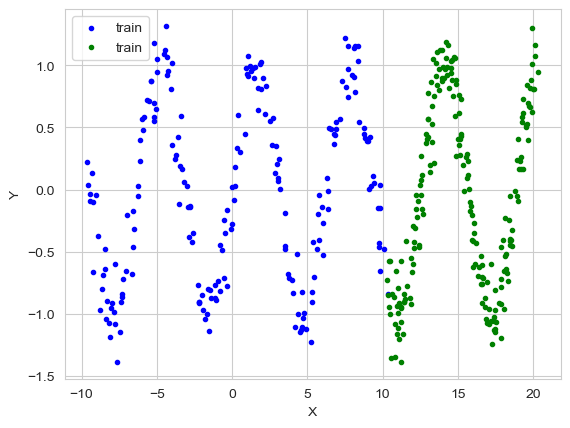

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(train_data.x, train_data.y, color = 'blue', marker = ".", label='train')
ax1.scatter(val_data.x, val_data.y, color = 'green', marker = ".", label='train')
plt.legend(loc='upper left')
plt.xlabel("X")
plt.ylabel("Y")

El dataset tiene entonces duplas de ventanas de predictores y valores a predecir. La idea es predecir un valor futuro dados los diez valores anteriores. Por ejemplo, veamos la primera dupla de datos generados con los primeros elementos de la serie.

In [14]:
train_data[0]

(tensor([[ 0.0347],
         [-0.0964],
         [ 0.2221],
         [-0.1022],
         [-0.0324],
         [-0.6660],
         [ 0.1338],
         [-0.3743],
         [-0.9699],
         [-0.0437]]),
 tensor([-0.6887]))

Vemos entonces lo que sería la ventana histórica de inputs (una secuencia de 10 valores), con la secuencia de valores a predecir en la ventana futura (una secuencia de un único valor en este caso).

Es importante notar que cada paso de tiempo en la ventana tiene un solo valor, ya que es una serie mono variable. Podríamos crear tambien series multivariables.

La podemos comparar con los primeros datos de la serie del dataset, incluyendo el(los) valor(es) futuro(s).

In [15]:
train_data.y[:train_data.ventanaPasado+train_data.ventanaFuturo]

tensor([ 0.0347, -0.0964,  0.2221, -0.1022, -0.0324, -0.6660,  0.1338, -0.3743,
        -0.9699, -0.0437, -0.6887])

In [16]:
train_data[0]

(tensor([[ 0.0347],
         [-0.0964],
         [ 0.2221],
         [-0.1022],
         [-0.0324],
         [-0.6660],
         [ 0.1338],
         [-0.3743],
         [-0.9699],
         [-0.0437]]),
 tensor([-0.6887]))

Ahora veamos la última dupla de datos generados con los últimos elementos de la serie.

In [17]:
train_data.y[-train_data.ventanaPasado-1:]

tensor([ 0.1088,  0.4257,  0.0547, -0.1508, -0.4667, -0.4311, -0.1495,  0.0323,
        -0.6581, -0.4804, -0.8395])

In [18]:
train_data[train_data.numPuntos-1]

(tensor([[ 0.1088],
         [ 0.4257],
         [ 0.0547],
         [-0.1508],
         [-0.4667],
         [-0.4311],
         [-0.1495],
         [ 0.0323],
         [-0.6581],
         [-0.4804]]),
 tensor([-0.8395]))

Ya que tenemos el dataset creado, vamos ahora a crear un `DataLoader` para poder obtener batches de entrenamiento y validación de cualquier modelo que vayamos a implementar.
El `DataLoader` de entrenamiento lo barajamos con `shuffle=True`, para no introducir sesgos de orden de presentación de instancias de aprendizale; el de test no requiere de ese tratamiento.

In [19]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=False)

Analicemos cómo sería la creación de un batch con los `DataLoader`.

In [20]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Train: Feature batch shape: {train_features.size()}")
print(f"Train: Labels batch shape: {train_labels.size()}")
val_features, val_labels = next(iter(val_dataloader))
print(f"Test: Feature batch shape: {val_features.size()}")
print(f"Test: Labels batch shape: {val_labels.size()}")

Train: Feature batch shape: torch.Size([32, 10, 1])
Train: Labels batch shape: torch.Size([32, 1])
Test: Feature batch shape: torch.Size([64, 10, 1])
Test: Labels batch shape: torch.Size([64, 1])


In [21]:
train_features[0]

tensor([[0.8995],
        [0.9842],
        [0.6420],
        [0.8177],
        [1.0309],
        [1.0142],
        [0.8136],
        [0.8965],
        [0.8326],
        [0.6111]])

In [22]:
train_labels[0]

tensor([0.5770])

Tenemos batches de 32 instancias; cada instancia de features tiene una ventana de tiempo (secuencia) con 10 valores consecutivos, y un label asociado con 1 solo valor de paso de tiempo futuro, tanto para training como para test.

# 3. Módulo LSTM de PyTorch

Vamos ahora a ilustrar como crear un modelo LSTM simple, utilizando la clase `torch.nn.LSTM`, que crea una un módulo con capas recurrentes apiladas, recibiendo como parámetros:
- `input_size`: el número de **variables de entrada** de la capa inicial. A no confundir con el tamaño de la secuencia, hablamos aquí de los *features*, por ejemplo, la temperatura, la presión atmosférica, la cantidad de precipitación.
- `hidden_size`: el número de **neuronas recurrentes** de cada capa apilada.
- `num_layers`: el número de **capas recurrentes** a apilar. Si tenemos mas de una capa, las capas subsiguientes reciben como entrada los outputs de las capas anteriores. Sabemos que no es una buena decisión arquitectural tener muchas capas recurrentes.
- `nonlinearity`: la **función de activación** a utilizar para calcular los estados escondidos $h_t$. Por defecto es `'tanh'`
- `batch_first`: Si es `True`, los tensores de entrada y de salida presentan los ejes en este orden **(batch_size, timesteps, input_features)** en vez de **(timesteps, batch_size, input_features)**. Esto no aplica para los estados intermedios, solo para entradas y salidas. Por defecto es `False`.
- `dropout`: si diferente de 0, probabilidad utilizada por capas de `Dropout` intermedias entre las capas recurrentes. Por defecto es 0.

Importante notar que el largo de las secuencias a tratar por las capas `LSTM` no tiene ninguna incidencia en la arquitectura de de las mismas (ni en el número de parámetros).

Creamos un modelo sencillo de una sola capa recurrente con 2 neuronas, que recibe 5 features de entrada, y que recibe los batches de instancias en el primer eje del tensor.

In [23]:
reset_seed()
lstm = nn.LSTM(input_size=5, hidden_size=2, num_layers=1, batch_first=True)

El módulo `LSTM` calcula el estado para cada capa a partir de la función de activación:
$$h_t = tanh({x_t​}W_{ih}^{T}+b_{ih}+{h_{t-1}​}W_{hh}^{T}+b_{hh})$$

Internamente se manejan 4 estructuras de parámetros por capa. Si tenemos una única capa (capa `'l0'`), tendremos:
- `weight_ih_l0`: matriz de pesos $W_{ih}$ que agrupa las 4 matrices de **parámetros que se aplican a los inputs del paso actual**, apiladas una encima de otra. Cada una de estas matrices tendrá un tamaño `[hidden_size, input_size]`, y la matriz global queda con un tamaño `[4*hidden_size, input_size]`:
  - $W_{ii}$: compuerta de consideración de la entrada el paso de tiempo actual
  - $W_{if}$: compuerta de olvido del estado escondido anterior
  - $W_{ig}$: pesos para establecer el estado de celda candidato
  - $W_{io}$: compuerta de salida del nuevo estado escondido
- `weight_hh_l0`: matriz de pesos $W_{ih}$ que agrupa las 4 matrices de **parámetros que se aplican a los estados escondidos del paso de tiempo anterior**, apiladas una encima de otra. Cada una de estas matrices es cuadrada `[hidden_size, hidden_size]`, por lo que queda una matriz global de tamaño `[4*hidden_size, hidden_size]`:
  - $W_{hi}$: compuerta de consideración de la entrada el paso de tiempo actual
  - $W_{hf}$: compuerta de olvido del estado escondido anterior
  - $W_{hg}$: pesos para establecer el estado de celda candidato
  - $W_{ho}$: compuerta de salida del nuevo estado escondido
- `bias_ih_l0`: vector de sesgos $b_{ih}$, que agrupa los sesgos que ajustan las 4 combinaciones lineales asociadas a los inputs del paso de tiempo actual, cada una de ellas tendría un sesgo para cada celda recurrente, teniendo el vector global un tamaño `[4*hidden_size]`.
- `bias_hh_l0`: vector de sesgos $b_{hh}$, que agrupa los sesgos que ajustan las 4 combinaciones lineales asociadas a los estados escondidos del paso de tiempo anterior, cada una de ellas tendría un sesgo para cada celda recurrente, teniendo el vector global un tamaño `[4*hidden_size]`.

Veamos los parámetros creados internamente por el modelo.

In [24]:
_=[print(param_name) for param_name in lstm.named_parameters()]

('weight_ih_l0', Parameter containing:
tensor([[ 0.5406,  0.5869, -0.1657,  0.6496, -0.1549],
        [ 0.1427, -0.3443,  0.4153,  0.6233, -0.5188],
        [ 0.6146,  0.1323,  0.5224,  0.0958,  0.3410],
        [-0.0998,  0.5451,  0.1045, -0.3301,  0.1802],
        [-0.3258, -0.0829, -0.2872,  0.4691, -0.5582],
        [-0.3260, -0.1997, -0.4252,  0.0667, -0.6984],
        [ 0.6386, -0.6007,  0.5459,  0.1177, -0.2296],
        [ 0.4370,  0.1102,  0.5713,  0.0773, -0.2230]], requires_grad=True))
('weight_hh_l0', Parameter containing:
tensor([[ 0.1900, -0.1918],
        [ 0.2976,  0.6313],
        [ 0.4087, -0.3091],
        [ 0.4082,  0.1265],
        [ 0.3591, -0.4310],
        [-0.7000, -0.2732],
        [-0.5424,  0.5802],
        [ 0.2037,  0.2929]], requires_grad=True))
('bias_ih_l0', Parameter containing:
tensor([ 0.2236, -0.0123,  0.5534, -0.5024,  0.0445, -0.4826,  0.2180, -0.2435],
       requires_grad=True))
('bias_hh_l0', Parameter containing:
tensor([ 0.2167, -0.1473,  0.58

In [25]:
print('weight_ih_l0:', lstm.weight_ih_l0.shape)
print('weight_hh_l0:', lstm.weight_hh_l0.shape)
print('bias_ih_l0:', lstm.bias_ih_l0.shape)
print('bias_hh_l0:', lstm.bias_hh_l0.shape)

weight_ih_l0: torch.Size([8, 5])
weight_hh_l0: torch.Size([8, 2])
bias_ih_l0: torch.Size([8])
bias_hh_l0: torch.Size([8])


Las redes recurrentes, sean estas **RNNs**, **LSTMs** o **GRUs**, tienen la posibilidad de considerar información de una secuencia en ambos sentidos, ya sea desde los primeros a los últimos términos, ya sea en el sentido inverso; pueden ser **bidireccionales**.
Esto permite considerar, en los casos en los que tenga sentido, tanto información previa como información posterior a un tiempo *t* sobre el cual se quiere hacer una inferencia. Por ejemplo, para identificar el rol de una palabra en NLP, se puede considerar información acerca de conjugaciones, plurales, géneros, etc, que aparezca antes o después del tiempo *t* en la secuencia.

Desde el punto de vista del funcionamiento, los procesos de la secuencia en los dos sentidos son **independientes**, y requieren de sus propios parámetros entrenables. Veamos cómo serían éstos para una capa `LSTM`, estableciendo el argumento `bidirectional=True` (por defecto, es `False`).

In [31]:
reset_seed()
lstm = nn.LSTM(input_size=5, hidden_size=2, num_layers=1, batch_first=True, bidirectional=True)

In [32]:
_=[print(param_name) for param_name in lstm.named_parameters()]

('weight_ih_l0', Parameter containing:
tensor([[ 0.5406,  0.5869, -0.1657,  0.6496, -0.1549],
        [ 0.1427, -0.3443,  0.4153,  0.6233, -0.5188],
        [ 0.6146,  0.1323,  0.5224,  0.0958,  0.3410],
        [-0.0998,  0.5451,  0.1045, -0.3301,  0.1802],
        [-0.3258, -0.0829, -0.2872,  0.4691, -0.5582],
        [-0.3260, -0.1997, -0.4252,  0.0667, -0.6984],
        [ 0.6386, -0.6007,  0.5459,  0.1177, -0.2296],
        [ 0.4370,  0.1102,  0.5713,  0.0773, -0.2230]], requires_grad=True))
('weight_hh_l0', Parameter containing:
tensor([[ 0.1900, -0.1918],
        [ 0.2976,  0.6313],
        [ 0.4087, -0.3091],
        [ 0.4082,  0.1265],
        [ 0.3591, -0.4310],
        [-0.7000, -0.2732],
        [-0.5424,  0.5802],
        [ 0.2037,  0.2929]], requires_grad=True))
('bias_ih_l0', Parameter containing:
tensor([ 0.2236, -0.0123,  0.5534, -0.5024,  0.0445, -0.4826,  0.2180, -0.2435],
       requires_grad=True))
('bias_hh_l0', Parameter containing:
tensor([ 0.2167, -0.1473,  0.58

Vemos que tenemos el doble de tensores en cuanto a los parámetros de la capa, la versión "de izquierda a derecha" con las estructuras ya explicadas, y una version `_reverse` con las matrices para el proceso "de derecha a izquierda".

In [33]:
print('weight_ih_l0:', lstm.weight_ih_l0.shape)
print('weight_hh_l0:', lstm.weight_hh_l0.shape)
print('bias_ih_l0:', lstm.bias_ih_l0.shape)
print('bias_hh_l0:', lstm.bias_hh_l0.shape)
print('weight_ih_l0_reverse:', lstm.weight_ih_l0_reverse.shape)
print('weight_hh_l0_reverse:', lstm.weight_hh_l0_reverse.shape)
print('bias_ih_l0_reverse:', lstm.bias_ih_l0_reverse.shape)
print('bias_hh_l0_reverse:', lstm.bias_hh_l0_reverse.shape)

weight_ih_l0: torch.Size([8, 5])
weight_hh_l0: torch.Size([8, 2])
bias_ih_l0: torch.Size([8])
bias_hh_l0: torch.Size([8])
weight_ih_l0_reverse: torch.Size([8, 5])
weight_hh_l0_reverse: torch.Size([8, 2])
bias_ih_l0_reverse: torch.Size([8])
bias_hh_l0_reverse: torch.Size([8])


## Funcionamiento interno

Retomamos la red unidireccional y vamos a entender su funcionamiento interno.

In [35]:
reset_seed()
lstm = nn.LSTM(input_size=5, hidden_size=2, num_layers=1, batch_first=True, bidirectional=False)

Vamos a crear un tensor de entrada para analizar su proceso a traves de la capa `LSTM`.

Para ilustrar, vamos a tener un batch de entrada con una única instancia, con secuencias de 3 pasos de tiempo para 5 features. Cada instancia tendra un tensor organizado así: (timesteps=3, input_features=5).

In [36]:
x_seq = torch.tensor([[1.0]*5, [2.0]*5, [3.0]*5]).float()
print(x_seq.shape)
print(x_seq)

torch.Size([3, 5])
tensor([[1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3.]])


El modulo `LSTM` espera un **tensor de entrada** cuyos ejes se organizan en el orden **(batch_size, timesteps, input_features)**, por lo que es necesario agregar el eje externo del batch con la única instancia.

In [37]:
print(torch.reshape(x_seq, (1, 3, 5)))

tensor([[[1., 1., 1., 1., 1.],
         [2., 2., 2., 2., 2.],
         [3., 3., 3., 3., 3.]]])


El llamado al módulo va a retornar tr4es tensores:
- un tensor de **outputs** con todos los estados de salida de las neuronas de la última capa recurrente (en este ejemplo una única capa), para todos los pasos de tiempo de la secuencia, cuyos ejes se organizan en  **(batch_size, timesteps, output_features)**.
- un tensor con los **estados escondidos** de salida del último paso para las neuronas de la última capa recurrente, cuyos ejes se organizan en  **(num_layers, batch_size, output_features)**. Estos están considerados en el tensor de **outputs**.
- un tensor con los **estados de celda** del último paso para las neuronas de la última capa recurrente, cuyos ejes se organizan en  **(num_layers, batch_size, output_features)**.

En cuanto a la salida del modelo, tendremos un valor por cada paso de tiempo de la secuencia, por cada una de las 2 neuronas de la última (en este caso única) capa del módulo recurrente.
Vamos ahora a enviar el tensor de prueba por el modelo para verificar su salida. Adicionalmente también habríamos podido enviar en el llamado un tensor con los estados iniciales $h_0$, y los estados de celda iniciales $c_0$, a considerar para todas las capas del módulo `LSTM`, pero al no enviarlo, estima un tensor con ceros por defecto.

In [38]:
output, (hn, cn) = lstm(torch.reshape(x_seq, (1, 3, 5)))
print("output:", output.shape, "\n  ",output)
print("hn:", hn.shape, "\n  ", hn)
print("cn:", hn.shape, "\n  ", cn)

output: torch.Size([1, 3, 2]) 
   tensor([[[-0.4848, -0.3527],
         [-0.8015, -0.5374],
         [-0.9065, -0.6685]]], grad_fn=<TransposeBackward0>)
hn: torch.Size([1, 1, 2]) 
   tensor([[[-0.9065, -0.6685]]], grad_fn=<StackBackward0>)
cn: torch.Size([1, 1, 2]) 
   tensor([[[-2.6153, -0.9048]]], grad_fn=<StackBackward0>)


Es importante notar que, al igual que con en el módulo `RNN`, **todos los pasos de tiempo se procesan uno después de otro en el módulo `LSTM` antes de producir las salidas**.
Vemos que los outputs tienen el valor de salida para cada neurona de la capa escondida para cada paso de tiempo. Las salidas del último paso de tiempo corresponde con el último estado de las neuronas escondidas.

Expliquemos ahora como se calcula el **feed forward** del modelo internamente. Vamos a tomar cada paso de tiempo a la vez, y crear la matriz con sus datos.

Vamos a extraer las matrices específicas para cada compuerta y cálculo de las matrices de pesos.

In [60]:
w_xh = lstm.weight_ih_l0
w_hh = lstm.weight_hh_l0
b_xh = lstm.bias_ih_l0
b_hh = lstm.bias_hh_l0

In [61]:
w_xi = w_xh[0:2, :]
w_xf = w_xh[2:4, :]
w_xg = w_xh[4:6, :]
w_xo = w_xh[6:8, :]
b_xi = b_xh[0:2]
b_xf = b_xh[2:4]
b_xg = b_xh[4:6]
b_xo = b_xh[6:8]

w_hi = w_hh[0:2, :]
w_hf = w_hh[2:4, :]
w_hg = w_hh[4:6, :]
w_ho = w_hh[6:8, :]
b_hi = b_hh[0:2]
b_hf = b_hh[2:4]
b_hg = b_hh[4:6]
b_ho = b_hh[6:8]

### Primer Paso de tiempo

In [52]:
paso=0

In [78]:
# input del primer paso
xt = torch.reshape(x_seq[0], (1, 5))
print("input:\n", xt)

input:
 tensor([[1., 1., 1., 1., 1.]])


Vamos a obviar los estados anteriores al ser el primer paso de tiempo, suponiendo inicializaciones en los estados iguales a cero.

In [82]:
prev_h = torch.zeros((lstm.hidden_size))
print("\nestados escondidos previos ht-1:\n", prev_h)

prev_c = torch.zeros((lstm.hidden_size))
print("\nestados de celda previos ct-1:\n", prev_c)


estados escondidos previos ht-1:
 tensor([0., 0.])

estados de celda previos ct-1:
 tensor([0., 0.])


#### Compuerta de input

Se evalúa si el valor candidato calculado para este paso de tiempo va a ser considerado o no.

In [83]:
print("matriz Wxi:\n", w_xi)
print("matriz Wxi transpuesta:\n", torch.transpose(w_xi, 0, 1))
print("sesgos bxi:\n",b_xi)

# combinación lineal de entrada: x*Wxi + bxi
xi = torch.matmul(xt, torch.transpose(w_xi, 0, 1)) + b_xi
print("\ncomb lineal entrada x*Wxi + bxi :\n", xi)

matriz Wxi:
 tensor([[ 0.5406,  0.5869, -0.1657,  0.6496, -0.1549],
        [ 0.1427, -0.3443,  0.4153,  0.6233, -0.5188]],
       grad_fn=<SliceBackward0>)
matriz Wxi transpuesta:
 tensor([[ 0.5406,  0.1427],
        [ 0.5869, -0.3443],
        [-0.1657,  0.4153],
        [ 0.6496,  0.6233],
        [-0.1549, -0.5188]], grad_fn=<TransposeBackward0>)
sesgos bxi:
 tensor([ 0.2236, -0.0123], grad_fn=<SliceBackward0>)

comb lineal entrada x*Wxi + bxi :
 tensor([[1.6801, 0.3060]], grad_fn=<AddBackward0>)


In [84]:
print("matriz Whi transpuesta:\n", torch.transpose(w_hi, 0, 1))
print("sesgos bhi:\n",b_hi)

# combinación lineal de estado escondido: x*Whi + bhi
hi = torch.matmul(prev_h, torch.transpose(w_hi, 0, 1)) + b_hi
print("\ncomb lineal estado escondido prev_h*Whi + bhi :\n", hi)

matriz Whi transpuesta:
 tensor([[ 0.1900,  0.2976],
        [-0.1918,  0.6313]], grad_fn=<TransposeBackward0>)
sesgos bhi:
 tensor([ 0.2167, -0.1473], grad_fn=<SliceBackward0>)

comb lineal estado escondido prev_h*Whi + bhi :
 tensor([ 0.2167, -0.1473], grad_fn=<AddBackward0>)


In [85]:
# valor de la compuerta de entrada
input_gate = torch.sigmoid(xi + hi)
print("input gate:\n", input_gate)

input gate:
 tensor([[0.8695, 0.5396]], grad_fn=<SigmoidBackward0>)


#### Compuerta de olvido

Se evalúa si se va a olvidar el estado de celda anterior o no.

In [89]:
print("matriz Wxf transpuesta:\n", torch.transpose(w_xf, 0, 1))
print("sesgos bxf:\n", b_xf)

# combinación lineal de entrada: x*Wxf + bxf
xf = torch.matmul(xt, torch.transpose(w_xf, 0, 1)) + b_xf
print("\ncomb lineal entrada x*Wxf + bxf :\n", xf)

print("matriz Whf transpuesta:\n", torch.transpose(w_hf, 0, 1))
print("sesgos bhf:\n", b_hf)

# combinación lineal de estado escondido: x*Whf + bhf
hf = torch.matmul(prev_h, torch.transpose(w_hf, 0, 1)) + b_hf
print("\ncomb lineal estado escondido prev_h*Whf + bhf :\n", hf)

# valor de la compuerta de olvido
forget_gate = torch.sigmoid(xf + hf)
print("input gate:\n", forget_gate)

matriz Wxf transpuesta:
 tensor([[ 0.6146, -0.0998],
        [ 0.1323,  0.5451],
        [ 0.5224,  0.1045],
        [ 0.0958, -0.3301],
        [ 0.3410,  0.1802]], grad_fn=<TransposeBackward0>)
sesgos bxf:
 tensor([ 0.5534, -0.5024], grad_fn=<SliceBackward0>)

comb lineal entrada x*Wxf + bxf :
 tensor([[ 2.2595, -0.1025]], grad_fn=<AddBackward0>)
matriz Whf transpuesta:
 tensor([[ 0.4087,  0.4082],
        [-0.3091,  0.1265]], grad_fn=<TransposeBackward0>)
sesgos bhf:
 tensor([ 0.5865, -0.4191], grad_fn=<SliceBackward0>)

comb lineal estado escondido prev_h*Whf + bhf :
 tensor([ 0.5865, -0.4191], grad_fn=<AddBackward0>)
input gate:
 tensor([[0.9451, 0.3725]], grad_fn=<SigmoidBackward0>)


#### Compuerta de salida

Se evalúa si la activación del estado de celda se debe tener en cuenta en la salida del estado escondido o no.

In [91]:
print("matriz Wxo transpuesta:\n", torch.transpose(w_xo, 0, 1))
print("sesgos bxo:\n", b_xf)

# combinación lineal de entrada: x*Wxo + bxo
xo = torch.matmul(xt, torch.transpose(w_xo, 0, 1)) + b_xo
print("\ncomb lineal entrada x*Wxo + bxo :\n", xo)

print("matriz Who transpuesta:\n", torch.transpose(w_ho, 0, 1))
print("sesgos bho:\n", b_ho)

# combinación lineal de estado escondido: x*Who + bho
ho = torch.matmul(prev_h, torch.transpose(w_ho, 0, 1)) + b_ho
print("\ncomb lineal estado escondido prev_h*Who + bho :\n", ho)

# valor de la compuerta de salida
output_gate = torch.sigmoid(xo + ho)
print("output gate:\n", output_gate)

matriz Wxo transpuesta:
 tensor([[ 0.6386,  0.4370],
        [-0.6007,  0.1102],
        [ 0.5459,  0.5713],
        [ 0.1177,  0.0773],
        [-0.2296, -0.2230]], grad_fn=<TransposeBackward0>)
sesgos bxo:
 tensor([ 0.5534, -0.5024], grad_fn=<SliceBackward0>)

comb lineal entrada x*Wxo + bxo :
 tensor([[0.6899, 0.7293]], grad_fn=<AddBackward0>)
matriz Who transpuesta:
 tensor([[-0.5424,  0.2037],
        [ 0.5802,  0.2929]], grad_fn=<TransposeBackward0>)
sesgos bho:
 tensor([0.6360, 0.2356], grad_fn=<SliceBackward0>)

comb lineal estado escondido prev_h*Who + bho :
 tensor([0.6360, 0.2356], grad_fn=<AddBackward0>)
output gate:
 tensor([[0.7902, 0.7241]], grad_fn=<SigmoidBackward0>)


#### Cómputo del valor candidato del paso actual

Se calcula el valor candidato a venir a actualizar los estados.

In [92]:
print("matriz Wxg transpuesta:\n", torch.transpose(w_xg, 0, 1))
print("sesgos bxg:\n", b_xf)

# combinación lineal de entrada: x*Wxg + bxg
xg = torch.matmul(xt, torch.transpose(w_xg, 0, 1)) + b_xg
print("\ncomb lineal entrada x*Wxg + bxg :\n", xg)

print("matriz Who transpuesta:\n", torch.transpose(w_hg, 0, 1))
print("sesgos bhg:\n", b_hg)

# combinación lineal de estado escondido: x*Whg + bhg
hg = torch.matmul(prev_h, torch.transpose(w_hg, 0, 1)) + b_hg
print("\ncomb lineal estado escondido prev_h*Whg + bhg :\n", hg)

# valor del estado candidato
candidate_value = torch.tanh(xg + hg)
print("candidate value:\n", candidate_value)

matriz Wxg transpuesta:
 tensor([[-0.3258, -0.3260],
        [-0.0829, -0.1997],
        [-0.2872, -0.4252],
        [ 0.4691,  0.0667],
        [-0.5582, -0.6984]], grad_fn=<TransposeBackward0>)
sesgos bxg:
 tensor([ 0.5534, -0.5024], grad_fn=<SliceBackward0>)

comb lineal entrada x*Wxg + bxg :
 tensor([[-0.7405, -2.0651]], grad_fn=<AddBackward0>)
matriz Who transpuesta:
 tensor([[ 0.3591, -0.7000],
        [-0.4310, -0.2732]], grad_fn=<TransposeBackward0>)
sesgos bhg:
 tensor([-0.4217, -0.4217], grad_fn=<SliceBackward0>)

comb lineal estado escondido prev_h*Whg + bhg :
 tensor([-0.4217, -0.4217], grad_fn=<AddBackward0>)
candidate value:
 tensor([[-0.8218, -0.9863]], grad_fn=<TanhBackward0>)


#### Cómputo de nuevo estado de celda

Se calcula el nuevo valor del estado de celda.

In [104]:
# estado de celda anterior
print("estado de celda anterior: ", prev_c)

# olvido del estado de celda anterior
new_c = torch.mul(prev_c, forget_gate)
print("post olvido del estado de celda anterior: ", new_c)

# aporte del nuevo valor candidato 
candidate_c = torch.mul(candidate_value, input_gate)
print("aporte del nuevo valor candidato: ", candidate_c)

# incorporación de valor candidato
new_c = new_c + candidate_c
print("nuevo valor de estado de celda: ", new_c)

estado de celda anterior:  tensor([0., 0.])
post olvido del estado de celda anterior:  tensor([[0., 0.]], grad_fn=<MulBackward0>)
aporte del nuevo valor candidato:  tensor([[-0.7145, -0.5322]], grad_fn=<MulBackward0>)
nuevo valor de estado de celda:  tensor([[-0.7145, -0.5322]], grad_fn=<AddBackward0>)


#### Cómputo de nuevo estado escondido

Se calcula el nuevo valor del estado escondido.

In [105]:
# estado  anterior
print("estado escondido anterior: ", prev_h)

# aporte del estado de celda de este paso de tiempo
cell_state_component = torch.tanh(new_c)
print("contribución del estado de celda actual: ", cell_state_component)

# nuevo valor del estado escondido
new_h = torch.mul(cell_state_component, output_gate)
print("nuevo valor de estado escondido: ", new_h)

estado escondido anterior:  tensor([0., 0.])
contribución del estado de celda actual:  tensor([[-0.6135, -0.4870]], grad_fn=<TanhBackward0>)
nuevo valor de estado escondido:  tensor([[-0.4848, -0.3527]], grad_fn=<MulBackward0>)


### Ciclo de proceso de la secuencia de datos

In [149]:
hidden_state_manual = [] # Aquí quedarán los estados temporales por cada paso de tiempo

# Inicialmente, los estados están en cero
prev_h = torch.zeros((lstm.hidden_size))
prev_c = torch.zeros((lstm.hidden_size))

# Recorremos los valores de los features por cada paso de tiempo
for t in range(3):
    # Preparamos los datos del paso de tiempo
    xt = torch.reshape(x_seq[t], (1, 5))
    print(f'Time step {t} =>')
    print(' Input :', xt.numpy())

    # Input Gate
    # combinación lineal de entrada: x*Wxi + bxi
    xi = torch.matmul(xt, torch.transpose(w_xi, 0, 1)) + b_xi
    # combinación lineal de estado escondido: x*Whi + bhi
    hi = torch.matmul(prev_h, torch.transpose(w_hi, 0, 1)) + b_hi
    # valor de la compuerta de entrada
    input_gate = torch.sigmoid(xi + hi)
    print(" input gate:", input_gate.detach().numpy())

    # Forget Gate
    # combinación lineal de entrada: x*Wxf + bxf
    xf = torch.matmul(xt, torch.transpose(w_xf, 0, 1)) + b_xf
    # combinación lineal de estado escondido: x*Whf + bhf
    hf = torch.matmul(prev_h, torch.transpose(w_hf, 0, 1)) + b_hf
    # valor de la compuerta de olvido
    forget_gate = torch.sigmoid(xf + hf)
    print(" forget gate:", forget_gate.detach().numpy())

    # Output Gate
    # combinación lineal de entrada: x*Wxo + bxo
    xo = torch.matmul(xt, torch.transpose(w_xo, 0, 1)) + b_xo
    # combinación lineal de estado escondido: x*Who + bho
    ho = torch.matmul(prev_h, torch.transpose(w_ho, 0, 1)) + b_ho
    # valor de la compuerta de salida
    output_gate = torch.sigmoid(xo + ho)
    print(" output gate:", output_gate.detach().numpy())

    # Candidate Value
    # combinación lineal de entrada: x*Wxg + bxg
    xg = torch.matmul(xt, torch.transpose(w_xg, 0, 1)) + b_xg
    # combinación lineal de estado escondido: x*Whg + bhg
    hg = torch.matmul(prev_h, torch.transpose(w_hg, 0, 1)) + b_hg
    # valor del estado candidato
    candidate_value = torch.tanh(xg + hg)
    print(" candidate value:", candidate_value.detach().numpy())

    # Nuevo estado de celda
    # olvido del estado de celda anterior
    new_c = torch.mul(prev_c, forget_gate)
    # aporte del nuevo valor candidato 
    candidate_c = torch.mul(candidate_value, input_gate)
    # incorporación de valor candidato
    new_c = new_c + candidate_c
    print(" nuevo valor de estado de celda: ", new_c.detach().numpy())

    # Nuevo estado escondido
    # aporte del estado de celda de este paso de tiempo
    cell_state_component = torch.tanh(new_c)
    # nuevo valor del estado escondido
    new_h = torch.mul(cell_state_component, output_gate)
    print(" nuevo valor de estado escondido: ", new_h.detach().numpy())

    hidden_state_manual.append(new_h.detach().numpy())
    prev_h = new_h
    prev_c = new_c
    print()

Time step 0 =>
 Input : [[1. 1. 1. 1. 1.]]
 input gate: [[0.8695272 0.5395849]]
 forget gate: [[0.945109   0.37247825]]
 output gate: [[0.7901701  0.72410244]]
 candidate value: [[-0.82175606 -0.9862599 ]]
 nuevo valor de estado de celda:  [[-0.7145393 -0.5321709]]
 nuevo valor de estado escondido:  [[-0.48478153 -0.352666  ]]

Time step 1 =>
 Input : [[2. 2. 2. 2. 2.]]
 input gate: [[0.9654035  0.52748525]]
 forget gate: [[0.98860264 0.40994614]]
 output gate: [[0.86485004 0.8501336 ]]
 candidate value: [[-0.9617929  -0.99860495]]
 nuevo valor de estado de celda:  [[-1.6349137 -0.7449108]]
 nuevo valor de estado escondido:  [[-0.8015068 -0.537372 ]]

Time step 2 =>
 Input : [[3. 3. 3. 3. 3.]]
 input gate: [[0.9915115 0.5541569]]
 forget gate: [[0.99775463 0.47080132]]
 output gate: [[0.91626865 0.9302033 ]]
 candidate value: [[-0.9924597  -0.99989843]]
 nuevo valor de estado de celda:  [[-2.615278  -0.9048056]]
 nuevo valor de estado escondido:  [[-0.9065158 -0.6684718]]



In [150]:
hidden_state_manual, (new_h.detach().numpy(), new_c.detach().numpy())

([array([[-0.48478153, -0.352666  ]], dtype=float32),
  array([[-0.8015068, -0.537372 ]], dtype=float32),
  array([[-0.9065158, -0.6684718]], dtype=float32)],
 (array([[-0.9065158, -0.6684718]], dtype=float32),
  array([[-2.615278 , -0.9048056]], dtype=float32)))

In [152]:
output.detach().numpy(), (hn.detach().numpy(), cn.detach().numpy())

(array([[[-0.48478153, -0.35266602],
         [-0.8015068 , -0.537372  ],
         [-0.9065157 , -0.6684719 ]]], dtype=float32),
 (array([[[-0.9065157, -0.6684719]]], dtype=float32),
  array([[[-2.6152778 , -0.90480566]]], dtype=float32)))

# 4. Modelo de forecasting con LSTMs y GRUs

Previamente utilizamos redes neuronales con capas recurrentes de tipo **Simple RNN**. 
Si bien todavía no hemos estudiado los modelos con capas recurrentes con arquitecturas más complejas com el **LSTM** o el **GRU**, vamos a utilizarlas en nuevos modelos de forecasting inspirados del modelo anterior. 


<span style="color: red;">Puntos a desarrollar:</span>
- <span style="color: red;">Defina una clase de modelo que incluya capas **LSTM**s en vez de **RNN**.</span>
- <span style="color: red;">Defina una clase de modelo que incluya capas **GRU**s en vez de **RNN**.</span>
- <span style="color: red;">Entrénelos buscando las mejores configuraciones de hiperparámetros.</span>
- <span style="color: red;">Calcule el RMSE, MAE y R2 de la predicción.</span>
- <span style="color: red;">Grafique la serie de entrenamiento, la de test, y los valores predichos.</span>